# Part 1
This Doc Computes the Gradient and the Slope for all of the volunteers 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, resize, downscale_local_mean
import math
import os
import numpy as np

import sigpy as sp
import sigpy.plot as pl
import seaborn as sns
from cmcrameri import cm

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import nrrd
import pingouin as pg
import scikit_posthocs as sp

from scipy.signal import argrelextrema

import sys
sys.path.append("/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python")
from mystic_mrpy.Data_Import.Diffusion   import *
from mystic_mrpy.Data_Sorting.Diffusion  import *
from mystic_mrpy.Diffusion.DWI  import *
from mystic_mrpy.Diffusion.Gibbs         import *
from mystic_mrpy.Diffusion.Registration  import *
from mystic_mrpy.Diffusion.Rejection     import *
from mystic_mrpy.Diffusion.Respiratory   import *
from mystic_mrpy.Diffusion.Averaging     import *
from mystic_mrpy.Diffusion.Denoising     import *
from mystic_mrpy.Diffusion.Interpolation import *
from mystic_mrpy.Diffusion.Segmentation_Matrix_DTI import *
from mystic_mrpy.Diffusion.DTI import *
from mystic_mrpy.Diffusion.cDTI import *

import numpy as np
import matplotlib.pyplot as plt

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
def get_bound(vector):
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,3), dpi=500)
    plot1=sns.histplot(np.reshape(vector[0],128*128),bins=20,kde=True,
                 stat = 'probability',binrange = [-math.pi,math.pi],ax = axes[0])
    
    plot2=sns.histplot(np.reshape(vector[1],128*128),bins=20,kde=True,
                 stat = 'probability',binrange = [-math.pi,math.pi],ax = axes[1])
    
    #plt.show() 
    plt.close(fig)  

    xx = plot1.get_lines()[0].get_xdata()
    
    yy = plot1.get_lines()[0].get_ydata()
    #print(np.unique(vector[1][~np.isnan(vector[0])]))
    
    
    minima = argrelextrema(yy,np.less)

    if minima[0].size >0:
        thresh_min_x = xx[minima[0][0]]
        if minima[0].shape[0] ==1:
            if xx[minima[0][0]]<0:
                thresh_min_x = xx[minima[0][0]]
                thresh_max_x = math.pi
            elif xx[minima[0][0]]>0:
                thresh_min_x = -math.pi
                thresh_max_x = xx[minima[0][0]]

        else:
            thresh_max_x = xx[minima[0][-1]]
    else:
        thresh_min_x = -math.pi
        thresh_max_x = math.pi
   
    xx = plot2.get_lines()[0].get_xdata()
    yy = plot2.get_lines()[0].get_ydata()
    minima = argrelextrema(yy,np.less)
    if minima[0].size >0:
        thresh_min_y = xx[minima[0][0]]
        if minima[0].shape[0] ==1:
            if xx[minima[0][0]]<0:
                thresh_min_y = xx[minima[0][0]]
                thresh_max_y = math.pi
            elif xx[minima[0][0]]>0:
                thresh_min_y = -math.pi
                thresh_max_y = xx[minima[0][0]]

        else:
            thresh_max_y = xx[minima[0][-1]]
    else:
        thresh_min_y = -math.pi
        thresh_max_y = math.pi
    #print('Thresh Min X',thresh_min_x,'Thresh Max X', thresh_max_x)
    #print('Thresh Min Y',thresh_min_y,'Thresh Max Y',thresh_max_y)

    if thresh_min_y > 0:
        thresh_min_y = -math.pi

    if thresh_min_x > 0:
        thresh_min_x = -math.pi

    if thresh_max_x < 0:
        thresh_min_x = math.pi
    
    if thresh_max_y < 0:
        thresh_min_y = math.pi
    
    index = np.argwhere(~np.isnan(vector[0]))
    for ii in range(index.shape[0]):
        idx = index[ii,0]
        idy = index[ii,1]
        if vector[0][idx,idy] > thresh_max_x:
            vector[0][idx,idy] -= math.pi
        
        if vector[0][idx,idy] < thresh_min_x:
            vector[0][idx,idy] += math.pi
            
        if vector[1][idx,idy] > thresh_max_y:
            vector[1][idx,idy] -= math.pi
        
        if vector[1][idx,idy] < thresh_min_y:
            vector[1][idx,idy] += math.pi
    
    del plot1,plot2,fig
    return vector
        
def calc_atten(vgrad_slope):   
    spins = 1000
    atten = vgrad_slope.copy()
    index = np.argwhere(~np.isnan(vgrad_slope))
    for ii in range(index.shape[0]):
        idx = index[ii,0]
        idy = index[ii,1]
        maxslope = vgrad_slope[idx,idy]
        
        phase = np.linspace(0,maxslope,spins)
        atten[idx,idy] = abs(np.sum(np.exp(1j*phase))/spins)
    
    return atten

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx


def main_bgphs(mag,base,mask):
    vgrad = np.gradient(base)*mask
    og = vgrad
    vgrad = get_bound(vgrad.copy())
    vgrad_slope = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
    atten = calc_atten(vgrad_slope)
    im_corrected = (mag)/(atten)
    return_grad = vgrad
    del vgrad
    return [im_corrected,return_grad,vgrad_slope]

In [3]:
volunteers=[1,2,3,4,5,7,8,9,10,11]
for vv in range(1):
    # Brain
    M0_mag = np.zeros((128,128,6,4,5,8))
    M1_mag = np.zeros((128,128,6,4,5,8))
    M2_mag = np.zeros((128,128,6,4,5,8))

    M0_phs = np.zeros((128,128,6,4,5,8))
    M1_phs = np.zeros((128,128,6,4,5,8))
    M2_phs = np.zeros((128,128,6,4,5,8))

    M0_mask = np.zeros((128,128,6,4,5,8))
    M1_mask = np.zeros((128,128,6,4,5,8))
    M2_mask = np.zeros((128,128,6,4,5,8))

    volunteer = str(volunteers[vv])
    inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Brain/V00' + volunteer + '/3_DWI/'
    name = inpath.split('/')
    namejoin = '/'.join(name[:-1])

    num = 0
    for num in range(3):
        nii_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.nii')]
        bval_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvals')]
        bvec_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvecs')]
        mask_files   = [_ for _ in os.listdir(inpath) if _.endswith('all.npy')]
        mask_end   = [_ for _ in os.listdir(inpath) if _.endswith('end.nrrd')]
        
        nii_files.sort()
        bval_files.sort()
        bvec_files.sort()
        mask_files.sort()
        mask_end.sort()

        data,affine, voxsize = load_nifti(os.path.join(inpath, nii_files[num]), return_voxsize=True)
        bvals = np.loadtxt(os.path.join(inpath,bval_files[num])) 
        bvecs = np.loadtxt(os.path.join(inpath,bvec_files[num]))
        mask = np.load(os.path.join(inpath,mask_files[num]))
        mask_end,header =  nrrd.read(os.path.join(inpath, mask_end[num]))
            
        # Use custom end slice masks 
        mask[:,:,0] = mask_end[:,:,0]
        mask[:,:,-1] = mask_end[:,:,-1]
        data1,bvals_sort,bvecs_sort = stacked2sorted(data,bvals,bvecs.T)
        
        ims = np.stack((data1[:,:,:,:,:5],data1[:,:,:,:,5:10],data1[:,:,:,:,10:15],
                            data1[:,:,:,:,15:20],data1[:,:,:,:,20:25],data1[:,:,:,:,25:30],
                            data1[:,:,:,:,30:35],data1[:,:,:,:,35:40]),axis = -1)  
            
        
        mag = abs(ims)
        phs = np.angle(ims)
        mask_rep = np.tile(mask[:,:,:,np.newaxis,np.newaxis,np.newaxis],(1,1,1,ims.shape[3],ims.shape[4],ims.shape[5]))
        mask_rep[mask_rep ==0] = np.nan
        
        if num == 0:
            M0_mag[:,:,:,:,:,:] = mag #* mask_rep
            M0_phs[:,:,:,:,:,:,] = phs #*mask_rep
            M0_mask[:,:,:,:,:,:] = mask_rep #*mask_rep
            
        if num == 1:
            M1_mag[:,:,:,:,:,:,] = mag #* mask_rep
            M1_phs[:,:,:,:,:,:] = phs #*mask_rep
            M1_mask[:,:,:,:,:,:] = mask_rep #*mask_rep
            
        if num == 2:
            M2_mag[:,:,:,:,:,:] = mag #* mask_rep
            M2_phs[:,:,:,:,:,:] = phs #*mask_rep
            M2_mask[:,:,:,:,:,:] = mask_rep #*mask_rep


    # NOT divide by the average 
    M0_adj = (np.exp(1j*M0_phs))/np.nanmean(np.exp(1j*M0_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
    M1_adj = (np.exp(1j*M1_phs))/np.nanmean(np.exp(1j*M1_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:] 
    M2_adj = (np.exp(1j*M2_phs))/np.nanmean(np.exp(1j*M2_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
    
    #M0_vgrad = np.zeros((2,128,128,6,4,5,8))
    #M1_vgrad = np.zeros((2,128,128,6,4,5,8))
    #M2_vgrad = np.zeros((2,128,128,6,4,5,8))

    M0_slope = np.zeros((128,128,6,4,5,8))
    M1_slope = np.zeros((128,128,6,4,5,8))
    M2_slope = np.zeros((128,128,6,4,5,8))


    for td in range(8):
        for sl in range(6):
            for diff in range(3,4):
                for rep in range(5):
                    #print(sl,diff,rep,end ='')
                    base =np.angle(M0_adj[:,:,sl,diff,rep,td]) 
                    mag=np.abs(M0_adj[:,:,sl,diff,rep,td]) 
                    [im_fix,grad,slope] =  main_bgphs(mag,base,M0_mask[:,:,sl,diff,rep,td])
                    #M0_vgrad[:,:,:,sl,diff,rep,td] = grad
                    M0_slope[:,:,sl,diff,rep,td] = slope
                    
                    base =np.angle(M1_adj[:,:,sl,diff,rep,td])
                    mag=np.abs(M1_adj[:,:,sl,diff,rep,td]) 
                    [im_fix,grad,slope] =  main_bgphs(mag,base,M1_mask[:,:,sl,diff,rep,td])
                    #M1_vgrad[:,:,:,sl,diff,rep,td] = grad
                    M1_slope[:,:,sl,diff,rep,td] = slope
                    
                    base =np.angle(M2_adj[:,:,sl,diff,rep,td]) 
                    mag=np.abs(M2_adj[:,:,sl,diff,rep,td]) 
                    [im_fix,grad,slope] =  main_bgphs(mag,base,M2_mask[:,:,sl,diff,rep,td])
                    #M2_vgrad[:,:,:,sl,diff,rep,td] = grad
                    M2_slope[:,:,sl,diff,rep,td] = slope
    print(vv)
    """
    savename = os.path.join(inpath,'M0_vgrad.npy')
    np.save(savename,M0_vgrad)

    savename = os.path.join(inpath,'M1_vgrad.npy')
    np.save(savename,M1_vgrad)

    savename = os.path.join(inpath,'M2_vgrad.npy')
    np.save(savename,M2_vgrad)
    """
    savename = os.path.join(inpath,'M0_slope.npy')
    np.save(savename,M0_slope)
    savename = os.path.join(inpath,'M1_slope.npy')
    np.save(savename,M1_slope)
    savename = os.path.join(inpath,'M2_slope.npy')
    np.save(savename,M2_slope)
    

KeyboardInterrupt: 

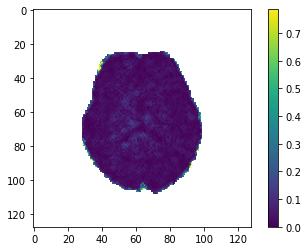

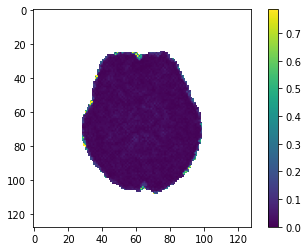

In [ ]:
plt.imshow(M2_slope[:,:,3,0,3,1],vmin =0,vmax = math.pi/4)
plt.colorbar()
plt.show()
plt.imshow(M0_slope[:,:,3,0,3,1],vmin =0,vmax = math.pi/4)
plt.colorbar()
plt.show()